In [2465]:
import numpy as np
import scipy.fft as fft
import scipy.signal as signal
from scipy.linalg import norm 
import matplotlib.pyplot as plt
%matplotlib inline

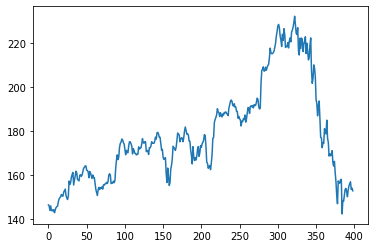

In [2466]:
import csv
stock_dates = []
stock_prices  = []
with open('AAPL.csv', mode='r') as raw_data:
    csv_reader = csv.DictReader(raw_data)
    for row in csv_reader:
        data = row['Close']
        if not data == 'null':
            stock_prices.append(float(data))
            stock_dates.append(row['Date'])
stock_prices = np.array(stock_prices)

# 400 most recent days
start = -400
end = -1
data = stock_prices[start:end]
plt.plot(data)

In [2467]:

#finds the frequency band that contains the given energy
def band(W, X, energy, gain):

    #remove the annoying negative values
    pX = np.array([])
    i = 0
    while W[i] != 0:
        pX = np.append(pX, X[i])
        i += 1

    e = 0.0
    w = 0
    nX = np.array([])

    while e < energy:
        nX = pX[:w]
        e = norm(nX)/np.pi
        w += 1
        print(e)

    return W[w]

In [2468]:
fft_len = 1000
data_fft = fft.fftshift(fft.fft(data, fft_len))
data_freq = fft.fftshift(fft.fftfreq(fft_len))

e_data = norm(data)**2
e_data_fft = norm(data_fft)**2
gain = e_data_fft/e_data

e = 0.5*e_data
print(e)
print("iter")
b = band(data_freq, data_fft, e, gain)
"""
plt.semilogx(data_freq, 20 * np.log10(abs(data_fft)))
plt.title('Market frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.axvline(b, color='green') # cutoff frequency
plt.show()
print(b)
"""

6428553.299398516
iter


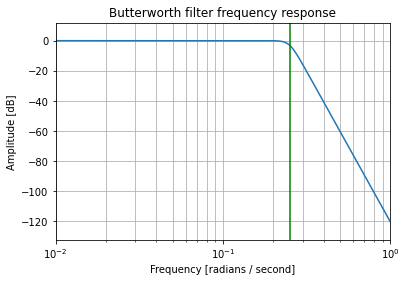

In [ ]:
N = 10
W = 2.5E-1

b, a = signal.butter(N, W, 'low', 'ba')
w, h = signal.freqs(b, a, fft_len)


plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(W, color='green') # cutoff frequency
plt.show()



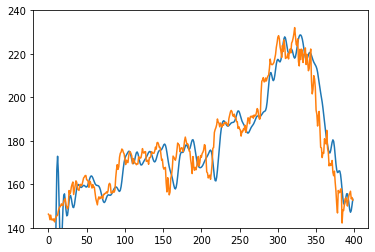

In [ ]:
sos = signal.butter(N, W, 'low', output='sos')
filtered = signal.sosfilt(sos, data)
plt.ylim([140, 240])
plt.plot(filtered)
plt.plot(data)

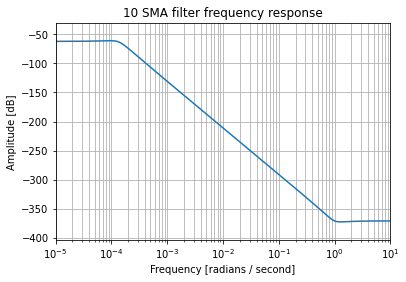

In [ ]:
L = 10
R = 5

b = np.array([1 for i in range(R)])
a = np.array([])
for s in range(R):
    s = R - s
    ao = 0
    for k in range(L):
        ao += np.exp(s*k)/L
    a = np.append(a, ao)

w, h = signal.freqs(b, a)

plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('{} SMA filter frequency response'.format(L))
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
#plt.axvline(W, color='green') # cutoff frequency
plt.show()